# 🎮 Proyek Data Science: Prediksi Penjualan Video Game
**Gabungan Analisis Regresi & Random Forest**

Notebook ini menggabungkan alur data science end-to-end:
1.  **Data Understanding:** Eksplorasi dataset & cleaning.
2.  **EDA:** Analisis korelasi & distribusi data.
3.  **Preprocessing:** Log transformation & One-Hot Encoding.
4.  **Modeling:** Komparasi Linear Regression vs Random Forest.
5.  **Deployment:** Simulasi prediksi untuk game baru.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Library Modeling & Evaluasi
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Konfigurasi visualisasi
sns.set(style="whitegrid")
%matplotlib inline

print("✅ Library berhasil di-load.")

✅ Library berhasil di-load.


In [2]:
# 1. Load Dataset
# Pastikan file 'Video_Games_Sales_as_at_22_Dec_2016.csv' sudah di-upload ke environment
file_name = 'Video_Games_Sales_as_at_22_Dec_2016.csv'

try:
    df = pd.read_csv(file_name)
    print(f"✅ Dataset berhasil dimuat. Dimensi awal: {df.shape}")
except FileNotFoundError:
    print("❌ File csv tidak ditemukan. Harap upload file terlebih dahulu.")

# 2. Cleaning Data
# Menangani nilai 'tbd' (to be decided) pada User_Score
df['User_Score'] = df['User_Score'].replace('tbd', np.nan)
df['User_Score'] = df['User_Score'].astype(float)

# Hapus baris yang memiliki Missing Values di kolom krusial
# Kita butuh data lengkap untuk training model yang akurat
cols_critical = ['Global_Sales', 'Critic_Score', 'User_Score', 'Year_of_Release', 'Publisher']
df_clean = df.dropna(subset=cols_critical).copy()

# Ubah Tahun menjadi Integer
df_clean['Year_of_Release'] = df_clean['Year_of_Release'].astype(int)

print(f"✅ Data setelah cleaning: {df_clean.shape}")
df_clean.head()

✅ Dataset berhasil dimuat. Dimensi awal: (16719, 16)
✅ Data setelah cleaning: (6893, 16)


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E
2,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E
6,New Super Mario Bros.,DS,2006,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,65.0,8.5,431.0,Nintendo,E
7,Wii Play,Wii,2006,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,6.6,129.0,Nintendo,E


## 📊 Exploratory Data Analysis (EDA)
Kita akan melihat distribusi data target (`Global_Sales`) dan mengecek korelasi antar fitur.

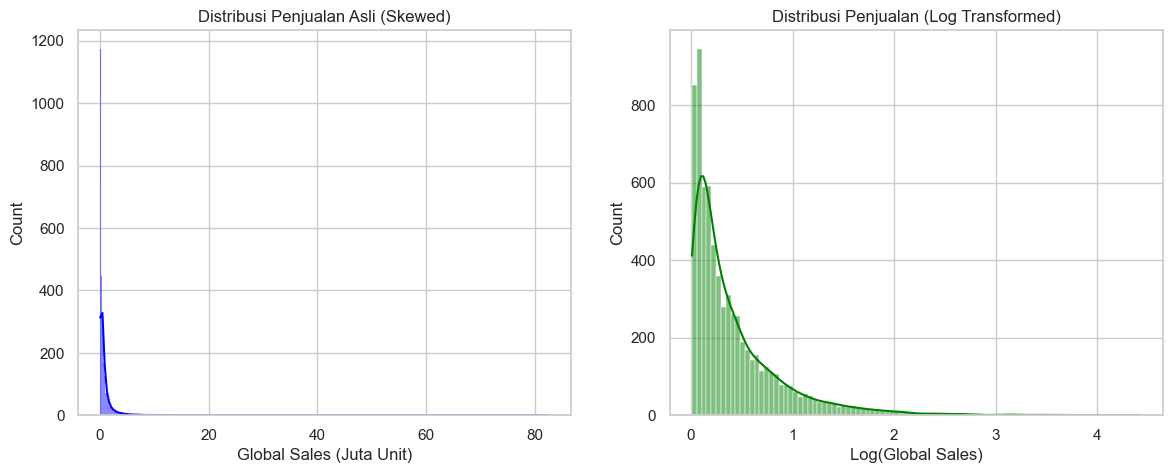

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_clean['Global_Sales'], kde=True, color='blue')
plt.title("Distribusi Penjualan Asli (Skewed)")
plt.xlabel("Global Sales (Juta Unit)")

df_clean['Global_Sales_Log'] = np.log1p(df_clean['Global_Sales'])

plt.subplot(1, 2, 2)
sns.histplot(df_clean['Global_Sales_Log'], kde=True, color='green')
plt.title("Distribusi Penjualan (Log Transformed)")
plt.xlabel("Log(Global Sales)")

plt.show()

C:\Users\ACER\AppData\Local\Temp\ipykernel_17124\484744511.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


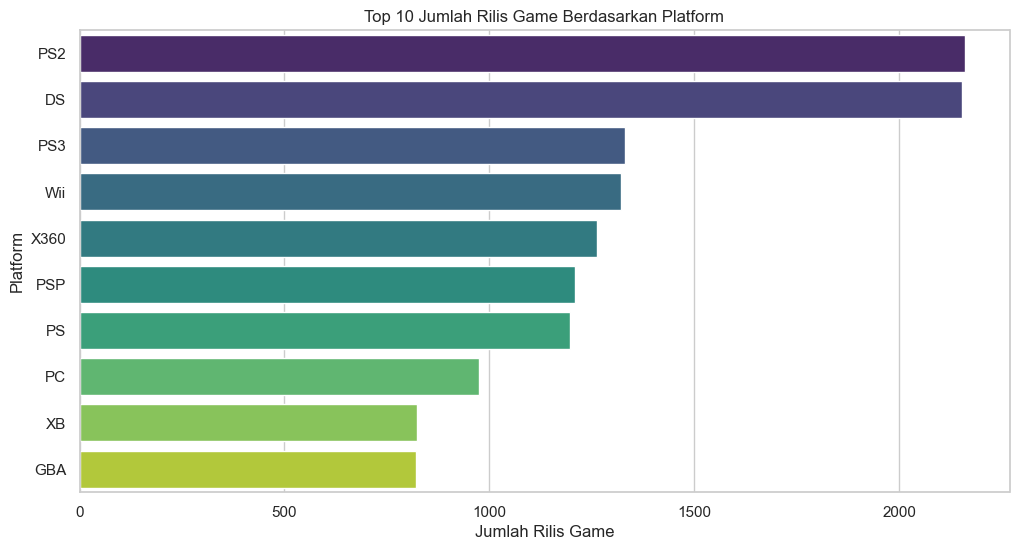

In [12]:
plt.figure(figsize=(12, 6))
sns.countplot(
    data=df, 
    y='Platform', 
    order=df['Platform'].value_counts().index[:10], # Ambil 10 platform teratas
    palette='viridis'
)
plt.title('Top 10 Jumlah Rilis Game Berdasarkan Platform')
plt.xlabel('Jumlah Rilis Game')
plt.ylabel('Platform')
plt.show()

C:\Users\ACER\AppData\Local\Temp\ipykernel_17124\962322893.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


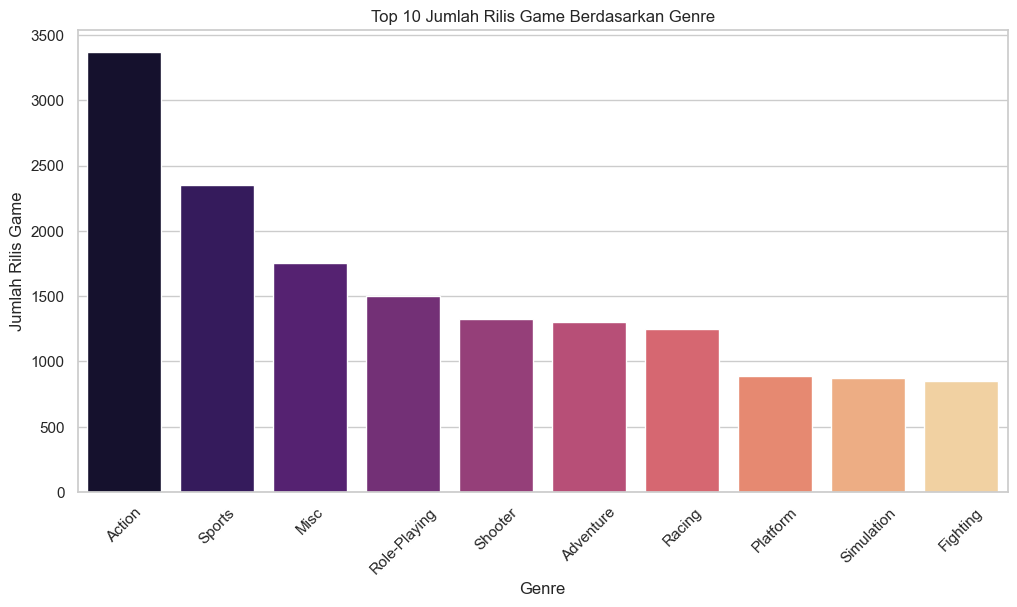

In [13]:
plt.figure(figsize=(12, 6))
sns.countplot(
    data=df, 
    x='Genre', 
    order=df['Genre'].value_counts().index[:10],
    palette='magma'
)
plt.title('Top 10 Jumlah Rilis Game Berdasarkan Genre')
plt.xlabel('Genre')
plt.ylabel('Jumlah Rilis Game')
plt.xticks(rotation=45)
plt.show()

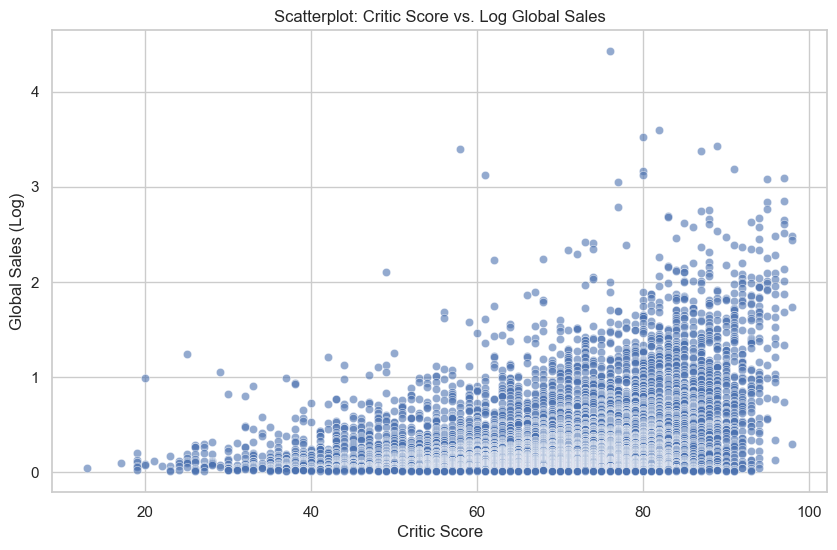

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Critic_Score', y='Global_Sales_Log', data=df, alpha=0.6)
plt.title('Scatterplot: Critic Score vs. Log Global Sales')
plt.xlabel('Critic Score')
plt.ylabel('Global Sales (Log)')
plt.show()

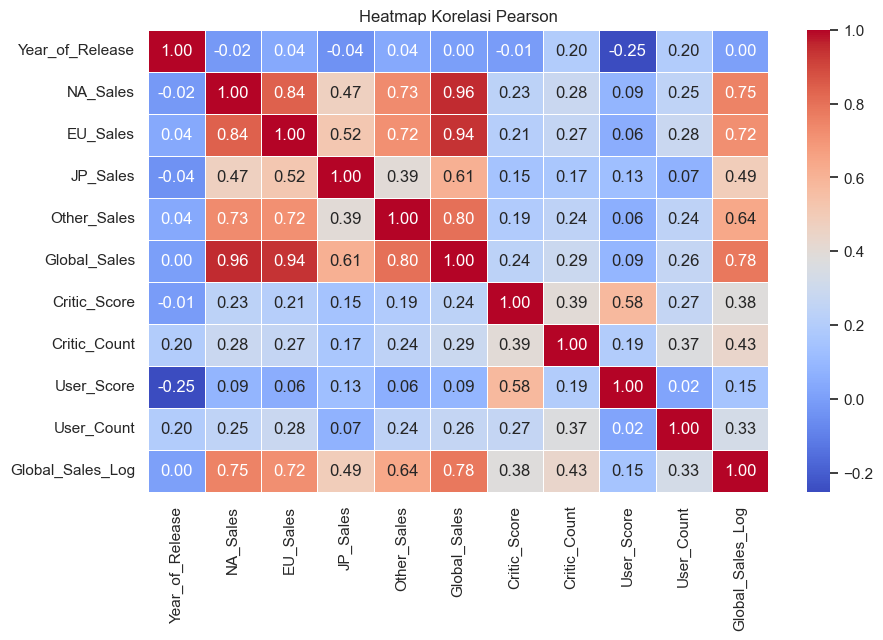

📌 Korelasi Pearson (Critic_Score vs Sales): r = 0.237


In [4]:
plt.figure(figsize=(10, 6))

# Ambil hanya kolom numerik untuk korelasi
numeric_df = df_clean.select_dtypes(include=[np.number])

# Gambar Heatmap
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heatmap Korelasi Pearson')
plt.show()

# Bukti Statistik
r, p = stats.pearsonr(df_clean['Critic_Score'], df_clean['Global_Sales'])
print(f"📌 Korelasi Pearson (Critic_Score vs Sales): r = {r:.3f}")

## 🛠 Data Preparation (Preprocessing)
Langkah ini menyiapkan data agar bisa diproses oleh mesin:
1. Membuang fitur yang tidak relevan atau bocor (data masa depan).
2. Melakukan Encoding untuk data kategori.
3. Membagi data menjadi Train & Test.

In [5]:
# 1. Hapus Fitur yang tidak dipakai
# NA_Sales, EU_Sales, dll dihapus karena itu adalah bagian dari Global_Sales (Data Leakage)
cols_to_drop = ['Name', 'Developer', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']
X_raw = df_clean.drop(columns=cols_to_drop + ['Global_Sales_Log']) # X adalah Fitur
y = df_clean['Global_Sales_Log'] # y adalah Target (Log Scale)

# 2. One-Hot Encoding (Mengubah teks Genre/Platform menjadi angka biner)
X = pd.get_dummies(X_raw, drop_first=True)

# 3. Splitting Data (80% Latih, 20% Uji)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"✅ Siap Modeling.")
print(f"Data Training: {X_train.shape}")
print(f"Data Testing : {X_test.shape}")

✅ Siap Modeling.
Data Training: (5514, 308)
Data Testing : (1379, 308)


## 🤖 Modeling & Evaluasi
Kita akan melatih dua model:
1. **Linear Regression**: Untuk melihat pengaruh variabel (Interpretability).
2. **Random Forest**: Untuk mendapatkan akurasi prediksi terbaik (Performance).

In [18]:
# --- Model 1: Linear Regression ---
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

# --- Model 2: Random Forest Regressor ---
# n_estimators=100 artinya menggunakan 100 pohon keputusan
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

print("✅ Kedua model berhasil dilatih!")

✅ Kedua model berhasil dilatih!



--- PERBANDINGAN PERFORMA MODEL ---
               Model  R2 Score      RMSE
0  Linear Regression  0.298144  1.380415
1      Random Forest  0.499385  1.165837


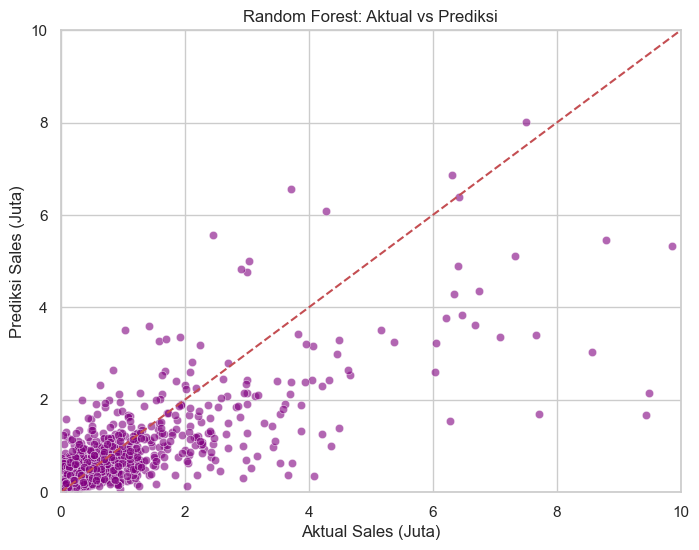

In [19]:
# Fungsi mengembalikan nilai log ke skala asli (Juta Unit)
def inverse_log(pred_log):
    return np.expm1(pred_log)

# Kembalikan ke skala asli
y_test_real = inverse_log(y_test)
y_pred_lr_real = inverse_log(y_pred_lr)
y_pred_rf_real = inverse_log(y_pred_rf)

# Hitung Metrik Evaluasi
metrics = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'R2 Score': [r2_score(y_test_real, y_pred_lr_real), r2_score(y_test_real, y_pred_rf_real)],
    'RMSE': [np.sqrt(mean_squared_error(y_test_real, y_pred_lr_real)), np.sqrt(mean_squared_error(y_test_real, y_pred_rf_real))]
})

print("\n--- PERBANDINGAN PERFORMA MODEL ---")
print(metrics)

# Visualisasi Prediksi vs Aktual (Random Forest)
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_real, y=y_pred_rf_real, alpha=0.6, color='purple')
plt.plot([0, 10], [0, 10], 'r--') # Garis diagonal sempurna
plt.xlabel("Aktual Sales (Juta)")
plt.ylabel("Prediksi Sales (Juta)")
plt.title("Random Forest: Aktual vs Prediksi")
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.show()

In [20]:
# Menggunakan Linear Regression untuk melihat bobot fitur
coef = pd.Series(model_lr.coef_, index=X.columns)

print("--- PENGARUH SKOR REVIEW ---")
print(f"Koefisien Critic Score: {coef.get('Critic_Score', 0):.5f}")
print(f"Koefisien User Score  : {coef.get('User_Score', 0):.5f}")

if coef.get('Critic_Score') > coef.get('User_Score'):
    print("\n💡 Insight: Penilaian Kritikus lebih berpengaruh terhadap penjualan daripada User.")
else:
    print("\n💡 Insight: Penilaian User lebih berpengaruh.")

--- PENGARUH SKOR REVIEW ---
Koefisien Critic Score: 0.00907
Koefisien User Score  : -0.02333

💡 Insight: Penilaian Kritikus lebih berpengaruh terhadap penjualan daripada User.


## 🚀 Simulasi Deployment
Mari kita coba prediksi penjualan untuk skenario game fiktif baru.


In [21]:
# 1. Buat template input data baru (diisi 0 semua dulu)
input_data = pd.DataFrame(columns=X_train.columns)
input_data.loc[0] = 0

# 2. Isi Spesifikasi Game Baru
# Skenario: Game 'Action' di 'PS4' dengan Review Sangat Bagus
input_data.loc[0, 'Year_of_Release'] = 2016
input_data.loc[0, 'Critic_Score'] = 95   # Skor Kritikus Tinggi
input_data.loc[0, 'User_Score'] = 9.0    # Skor User Tinggi
input_data.loc[0, 'Critic_Count'] = 60
input_data.loc[0, 'User_Count'] = 2500

# Set Kategori (One-Hot Encoding manual)
if 'Platform_PS4' in input_data.columns:
    input_data.loc[0, 'Platform_PS4'] = 1
if 'Genre_Action' in input_data.columns:
    input_data.loc[0, 'Genre_Action'] = 1

# 3. Lakukan Prediksi
# Prediksi masih dalam bentuk Log
pred_log = model_rf.predict(input_data)[0]
# Kembalikan ke bentuk Juta Unit
pred_real = np.expm1(pred_log)

print("="*40)
print(f"🎮 Skenario Game Baru (PS4, Action, Rating 95/100)")
print(f"💰 Prediksi Penjualan Global: {pred_real:.2f} Juta Unit")
print("="*40)

🎮 Skenario Game Baru (PS4, Action, Rating 95/100)
💰 Prediksi Penjualan Global: 4.06 Juta Unit


In [6]:
df_clean.to_csv('vgsales_clean_for_submission.csv', index=False)
print("✅ Dataset bersih telah disimpan sebagai 'vgsales_clean_for_submission.csv'")

✅ Dataset bersih telah disimpan sebagai 'vgsales_clean_for_submission.csv'
